In [32]:
import pandas as pd
import numpy as np
import glob
import json # Import the json library

# Parameters (tunable)
BASE_PRICE = 7.0   # ₹/kWh grid price baseline
ALPHA = 5.0        # Solar abundance price sensitivity
BETA = 0.125         # Buyer discount below grid

# Gather all CSVs into one DataFrame
files = sorted(glob.glob('HH*.csv'))
all_data = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)


# Household PV sizes and types
with open('dataset_summary.json', 'r') as f:
    dataset_summary = json.load(f)
households = dataset_summary['households']

print(households)


[{'household_id': 'HH001', 'type': 'prosumer', 'monthly_kwh_target': 94.98, 'pv_kw': 3.45, 'total_load_kwh': 19.54, 'total_solar_kwh': 110.6, 'net_kwh': 91.06, 'num_outages': 3, 'records': 168}, {'household_id': 'HH002', 'type': 'prosumer', 'monthly_kwh_target': 109.28, 'pv_kw': 3.1, 'total_load_kwh': 24.9, 'total_solar_kwh': 99.31, 'net_kwh': 74.41, 'num_outages': 1, 'records': 168}, {'household_id': 'HH003', 'type': 'prosumer', 'monthly_kwh_target': 86.24, 'pv_kw': 2.66, 'total_load_kwh': 17.98, 'total_solar_kwh': 85.13, 'net_kwh': 67.14, 'num_outages': 2, 'records': 168}, {'household_id': 'HH004', 'type': 'consumer', 'monthly_kwh_target': 204.65, 'pv_kw': 1.11, 'total_load_kwh': 46.21, 'total_solar_kwh': 35.46, 'net_kwh': -10.75, 'num_outages': 2, 'records': 168}, {'household_id': 'HH005', 'type': 'consumer', 'monthly_kwh_target': 248.09, 'pv_kw': 1.0, 'total_load_kwh': 57.18, 'total_solar_kwh': 31.91, 'net_kwh': -25.27, 'num_outages': 2, 'records': 168}, {'household_id': 'HH006', '

In [33]:
hh_info = {h['household_id']: h for h in households}

results = []
for ts, group in all_data.groupby('timestamp'):
    bids, asks, sold_qty = [], [], []
    for _, row in group.iterrows():
        hhid, load, solar = row['household_id'], row['load_kW'], row['solar_kW']
        pv_size = hh_info[hhid]['pv_kw']
        solar_norm = min(solar / pv_size, 1.0) if pv_size > 0 else 0
        surplus = solar - load

        if surplus >= 0:  # Seller
            ask_price = BASE_PRICE - (ALPHA * solar_norm)
            asks.append({'hhid': hhid, 'qty': surplus, 'price': ask_price})
        else:             # Buyer
            bid_price = BASE_PRICE - BETA
            bids.append({'hhid': hhid, 'qty': -surplus, 'price': bid_price})

    # Sort bids desc, asks asc
    bids_sorted = sorted(bids, key=lambda x: -x['price'])
    asks_sorted = sorted(asks, key=lambda x: x['price'])

    # Auction clearing (Greedy intersection)
    traded, b_idx, a_idx = 0, 0, 0
    quantities, buyer_ids, seller_ids = [], [], []
    while b_idx < len(bids_sorted) and a_idx < len(asks_sorted):
        if bids_sorted[b_idx]['price'] >= asks_sorted[a_idx]['price']:
            trade_qty = min(bids_sorted[b_idx]['qty'], asks_sorted[a_idx]['qty'])
            traded += trade_qty
            quantities.append(trade_qty)
            buyer_ids.append(bids_sorted[b_idx]['hhid'])
            seller_ids.append(asks_sorted[a_idx]['hhid'])
            bids_sorted[b_idx]['qty'] -= trade_qty
            asks_sorted[a_idx]['qty'] -= trade_qty
            if bids_sorted[b_idx]['qty'] == 0: b_idx += 1
            if asks_sorted[a_idx]['qty'] == 0: a_idx += 1
        else:
            break

    # Market Clearing Price (average of marginal prices or fallback)
    clearing_price = (bids_sorted[b_idx-1]['price'] + asks_sorted[a_idx-1]['price']) / 2 if traded else BASE_PRICE

    # Grid-only cost for traded buyers
    grid_cost = sum([BASE_PRICE * q for q in quantities])
    auction_cost = sum([clearing_price * q for q in quantities])
    cost_savings = grid_cost - auction_cost

    results.append({
        'timestamp': ts,
        'clearing_price': clearing_price,
        'total_traded_kwh': traded,
        'cost_savings': cost_savings,
        'n_trades': len(quantities)
    })

summary_df = pd.DataFrame(results)
summary_df.to_csv('summary_df.csv')

In [34]:
summary_df

,timestamp,clearing_price,total_traded_kwh,cost_savings,n_trades
0,2024-06-01 00:00:00,7.000000,0.0000,0.000000,0
1,2024-06-01 01:00:00,6.679041,0.0577,0.018519,3
2,2024-06-01 02:00:00,7.000000,0.0000,0.000000,0
3,2024-06-01 03:00:00,7.000000,0.0000,0.000000,0
4,2024-06-01 04:00:00,7.000000,0.0000,0.000000,0
...,...,...,...,...,...
163,2024-06-07 19:00:00,7.000000,0.0000,0.000000,0
164,2024-06-07 20:00:00,7.000000,0.0000,0.000000,0
165,2024-06-07 21:00:00,7.000000,0.0000,0.000000,0
166,2024-06-07 22:00:00,7.000000,0.0000,0.000000,0


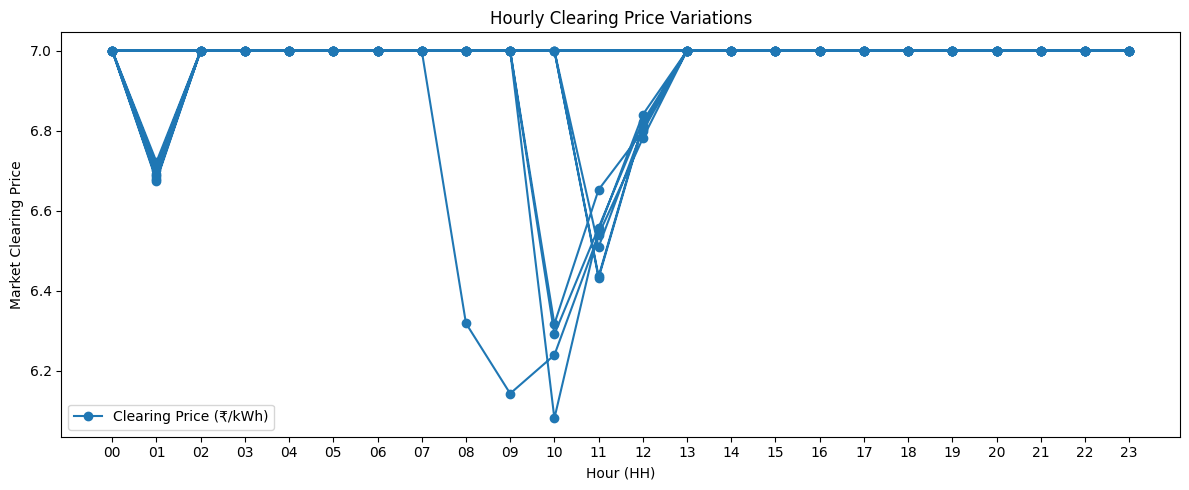

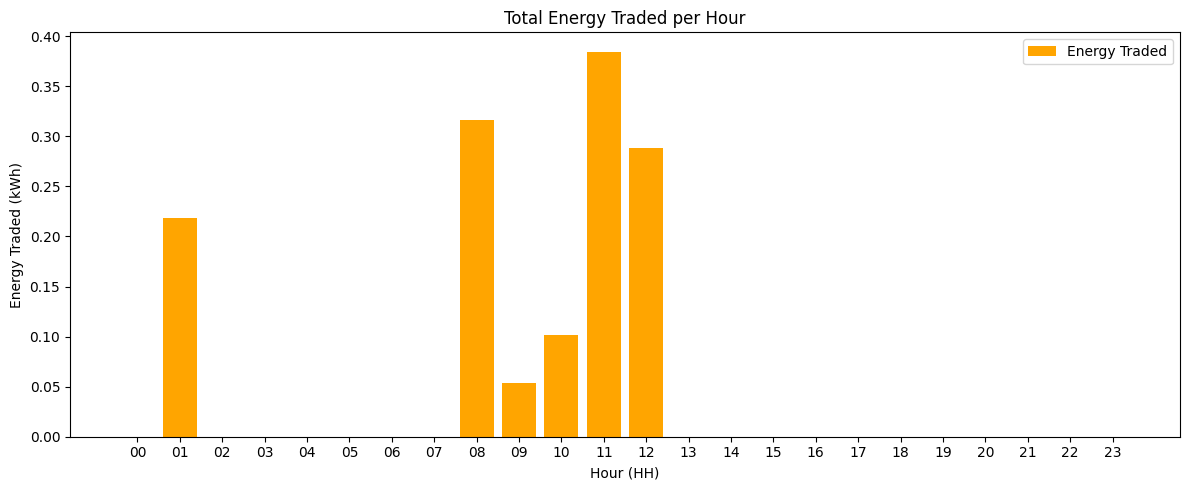

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

summary_df['timestamp'] = pd.to_datetime(summary_df['timestamp'])

hour_labels = summary_df['timestamp'].dt.strftime('%H')

plt.figure(figsize=(12, 5))
plt.plot(hour_labels, summary_df['clearing_price'], marker='o', label='Clearing Price (₹/kWh)')
plt.ylabel('Market Clearing Price')
plt.xlabel('Hour (HH)')
plt.title('Hourly Clearing Price Variations')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.bar(hour_labels, summary_df['total_traded_kwh'], color='orange', label='Energy Traded')
plt.ylabel('Energy Traded (kWh)')
plt.xlabel('Hour (HH)')
plt.title('Total Energy Traded per Hour')
plt.legend()
plt.tight_layout()
plt.show()
